In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode
!pip install ipython

# ## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

# End-to-End Speaker Diarization in NeMo

Traditional cascaded (also referred to as modular or pipelined) speaker diarization systems consists of multiple modules such as speaker activity detection (SAD) module and speaker embedding extractor moddule. Cascaded systems are often time-consuming to develop since each model should be separately trained and optimized. 

On the other hand, end-to-end speaker diarization systems pursue a much more simplified version of system where a single neural network model that accepts raw audio signal and outputs speaker activity for each audio frame. 

## Sortformer Diarization Inference

As explained in the [Sortformer Diarization Training](https://github.com/NVIDIA/NeMo/blob/main/tutorials/speaker_tasks/Speaker_Diarization_Training.ipynb) tutorial, Sortformer is trained with Sort-Loss to generate speaker segments in arrival-time order. If a diarization model can generate speaker segments in a pre-defined rule or order, we do not need to match the permutations when we train diarization model with multi-speaker automatic speech recognition (ASR) models or we do not need to match permutations from each window when a diarization model is running in streaming mode where audio chunk sequences are processed, creating a problem of permutation matchin between inference windows. 

<img src="images/intro_comparison.png" alt="PIL model VS SortLoss model" style="width: 800px;"/>

### A toy example for speaker diarization with a Sortformer model 

Download a toy example audio file (`an4_diarize_test.wav`) and its ground-truth label file (`an4_diarize_test.rttm`).

In [2]:
import os
import wget
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data')
os.makedirs(data_dir, exist_ok=True)
an4_audio = os.path.join(data_dir,'an4_diarize_test.wav')
an4_rttm = os.path.join(data_dir,'an4_diarize_test.rttm')
if not os.path.exists(an4_audio):
    an4_audio_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.wav"
    an4_audio = wget.download(an4_audio_url, data_dir)
if not os.path.exists(an4_rttm):
    an4_rttm_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.rttm"
    an4_rttm = wget.download(an4_rttm_url, data_dir)

Let's plot and listen to the audio. Pay attention to the two speakers in the audio clip.

/home/taejinp/anaconda3/envs/nv121824/lib/python3.10/site-packages/librosa/core/audio.py:13: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  import scipy


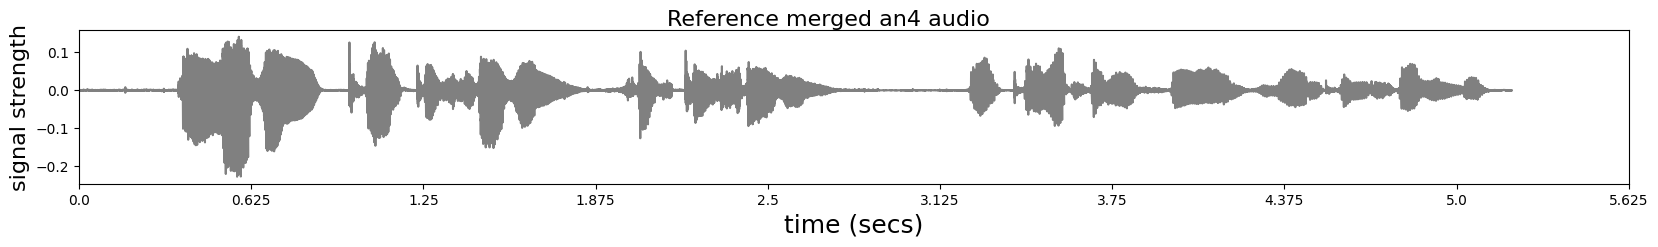

In [3]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import librosa

sr = 16000
signal, sr = librosa.load(an4_audio,sr=sr) 

fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Reference merged an4 audio', fontsize=16)
plt.xlabel('time (secs)', fontsize=18)
ax.margins(x=0)
plt.ylabel('signal strength', fontsize=16)
a,_ = plt.xticks();plt.xticks(a,a/sr)

IPython.display.Audio(an4_audio)

Now that we have downloaded the example audio file contains multiple speakers, we can feed the audio clip into Sortformer diarizer and get the speaker diarization results.

To download Sortformer diarizer from [Sortformer HuggingFace model card](https://huggingface.co/nvidia/diar_sortformer_4spk-v1), you need to get a [HuggingFace Acces Token](https://huggingface.co/docs/hub/en/security-tokens) and feed your access token in your python environment using [HuggingFace CLI](https://huggingface.co/docs/huggingface_hub/main/en/guides/cli).

If you are having trouble getting a HuggingFace token, you can download Sortformer model from [Sortformer HuggingFace model card](https://huggingface.co/nvidia/diar_sortformer_4spk-v1) and specify the path to the downloaded model.

When excuting `diarize()` function, if you specify `include_tensor_outputs=True`, the diarization model will return the predicted speaker-labeled segments and tensors containing T by N (N is number of max speakers) sigmoid values for each audio frame. 

Without `include_tensor_outputs` variable or `include_tensor_outputs=False`, only speaker labeled segments will be returned.

In [12]:
from nemo.collections.asr.models import SortformerEncLabelModel
from huggingface_hub import get_token as get_hf_token
import torch

if get_hf_token() is not None and get_hf_token().startswith("hf_"):
    # If you have logged into HuggingFace hub and have access token 
    diar_model = SortformerEncLabelModel.from_pretrained("nvidia/diar_sortformer_4spk-v1")
else:
    # You can downloaded ".nemo" file from https://huggingface.co/nvidia/diar_sortformer_4spk-v1 and specify the path.
    diar_model = SortformerEncLabelModel.restore_from(restore_path="/path/to/diar_sortformer_4spk-v1.nemo", map_location=torch.device('cuda'), strict=False)

pred_list, pred_tensor_list = diar_model.diarize(audio=an4_audio, include_tensor_outputs=True)

print(pred_list[0])
print(pred_tensor_list[0].shape)


[NeMo W 2024-12-20 16:19:49 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    num_spks: 4
    session_len_sec: 90
    soft_label_thres: 0.5
    soft_targets: false
    labels: null
    batch_size: 4
    shuffle: true
    num_workers: 18
    validation_mode: false
    use_lhotse: false
    use_bucketing: false
    num_buckets: 10
    bucket_duration_bins:
    - 10
    - 20
    - 30
    - 40
    - 50
    - 60
    - 70
    - 80
    - 90
    pin_memory: true
    min_duration: 80
    max_duration: 90
    batch_duration: 400
    quadratic_duration: 1200
    bucket_buffer_size: 20000
    shuffle_buffer_size: 10000
    window_stride: 0.01
    subsampling_factor: 8
    
[NeMo W 2024-12-20 16:19:49 modelPT:183] If you intend to do validation, please call the ModelPT.setup_validation_data() or

[NeMo I 2024-12-20 16:19:49 features:305] PADDING: 16
[NeMo I 2024-12-20 16:19:51 save_restore_connector:275] Model SortformerEncLabelModel was successfully restored from /home/taejinp/.cache/huggingface/hub/models--nvidia--diar_sortformer_4spk-v1/snapshots/992636d4552cc94fb80acfce378793bfd32dd9bd/diar_sortformer_4spk-v1.nemo.
[NeMo I 2024-12-20 16:19:51 vad_utils:81] No postprocessing YAML file has been provided. Default postprocessing configurations will be applied.


Diarizing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]

['0.400 2.880 speaker_0', '3.280 5.270 speaker_1']
torch.Size([1, 66, 4])



Now let's visualize the predicted speaker diarization results. The diarization model outputs a tensor where each row represents a speaker and each column represents a frame. The sigmoid values in the tensor represent the probability of the frame being spoken by that speaker.

In the following code, we'll plot the predicted speaker diarization results for the sample audio file.

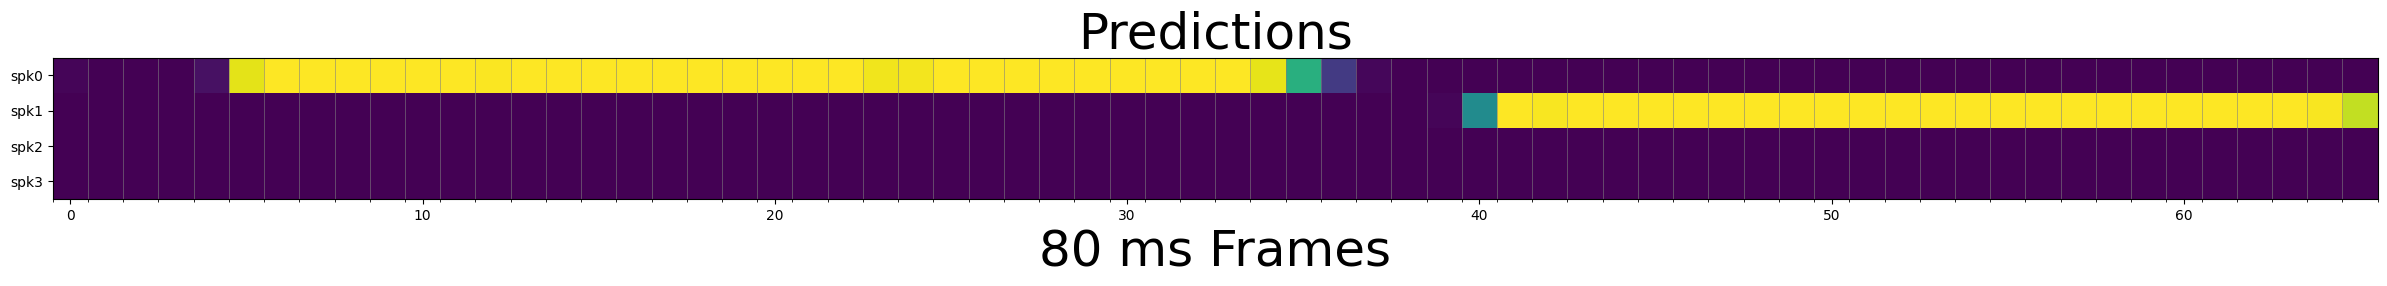

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_diarout(preds, sample_idx):
    preds_mat = preds[sample_idx].cpu().numpy().transpose()
    cmap_str, grid_color_p= 'viridis', 'gray'
    LW, FS = 0.4, 36

    yticklabels = ["spk0", "spk1", "spk2", "spk3"]
    yticks = np.arange(len(yticklabels))
    fig, axs = plt.subplots(1, 1, figsize=(30, 3))  # 1 row, 2 columns for preds and targets

    axs.imshow(preds_mat, cmap=cmap_str, interpolation='nearest') #, aspect=aspect_float)
    axs.set_title('Predictions', fontsize=FS)
    axs.set_xticks(np.arange(-.5, preds_mat.shape[1], 1), minor=True)
    axs.set_yticks(yticks)
    axs.set_yticklabels(yticklabels)
    axs.set_xlabel(f"80 ms Frames", fontsize=FS)
    axs.grid(which='minor', color=grid_color_p, linestyle='-', linewidth=LW)

    plt.savefig('plot.png', dpi=300) # bbox_inches='tight')
    plt.show()


plot_diarout(pred_tensor_list[0], sample_idx=0)

Note that the first speaker always gets the first generic speaker label `spk0`. Sortformer model is trained to generate speaker labels in arrival time order, thus permutations of speakers are always predictable if we know the arrival time order of speakers.

## Post-Processing of Speaker Timestamps

In the previous steps, we have obtained predictions of speaker activity in a form of Tensors. While the floating point probability values can be interpreted as speaker probabilities, these values are not designed to consumed as is and still requires to be processed to be segment information which has start and end time for each time stamp.



In [6]:
from omegaconf import OmegaConf
import os
import wget
import pandas as pd
from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels, labels_to_pyannote_object
from pyannote.metrics.diarization import DiarizationErrorRate

ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data')

# MODEL_CONFIG = os.path.join(data_dir,'sortformer_diar_4spk-v1_callhome-part1.yaml')
yaml_name="sortformer_diar_4spk-v1_dihard3-dev.yaml"
MODEL_CONFIG = os.path.join(data_dir, yaml_name)
# if not os.path.exists(MODEL_CONFIG):
if True:
    config_url = f"https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/post_processing/{yaml_name}"
    MODEL_CONFIG = wget.download(config_url, data_dir)


The post-processing yaml file `sortformer_diar_4spk-v1_dihard3-dev.yaml` is containing parameters that are optimized to have the lowest Diarization Error Rate (DER) on the [DiHARD 3 development set](https://catalog.ldc.upenn.edu/LDC2022S12).

In [7]:
from nemo.collections.asr.parts.utils.vad_utils import load_postprocessing_from_yaml
import json
from omegaconf import OmegaConf 
post_processing_params = load_postprocessing_from_yaml(MODEL_CONFIG)
print(json.dumps(OmegaConf.to_container(post_processing_params), indent=4))

[NeMo I 2024-12-20 15:55:33 vad_utils:89] Postprocessing YAML file '/home/taejinp/projects/sortformer_docs/NeMo/tutorials/speaker_tasks/data/sortformer_diar_4spk-v1_dihard3-dev (1).yaml' has been loaded.
{
    "onset": 0.64,
    "offset": 0.74,
    "pad_onset": 0.06,
    "pad_offset": 0.0,
    "min_duration_on": 0.1,
    "min_duration_off": 0.15
}


The parameters in post-processing yaml configurations perform the following tasks:

| **Parameter**      | **Description**                                               |
|-------------------:|--------------------------------------------------------------|
| **onset**          | Onset threshold for detecting the beginning of a speech segment. |
| **offset**         | Offset threshold for detecting the end of a speech segment.      |
| **pad_onset**      | Adds the specified duration at the beginning of each speech segment. |
| **pad_offset**     | Adds the specified duration at the end of each speech segment.     |
| **min_duration_on**| Removes short silences if the duration is less than the specified minimum duration. |
| **min_duration_off**| Removes short speech segments if the duration is less than the specified minimum duration. |

Now let's check the diarization output timestamps and compare how post-processing changes the diarization output.

In [11]:

def show_diar_df(pred_session_list):
    data = [segment.split() for segment in pred_session_list]
    df = pd.DataFrame(data, columns=['Start Time', 'End Time', 'Speaker'])
    print(df)

# Call `diarize` method without postprocessing params
pred_list_bn = diar_model.diarize(audio=an4_audio)
# "data/input_manifest.json")
print(f"  [Default Binarized Diarization Output]: ")
show_diar_df(pred_list_bn[0])

# Call `diarize` method with postprocessing params
pred_list_pp = diar_model.diarize(audio=an4_audio, postprocessing_yaml=MODEL_CONFIG)
print(f"  [Post-processed Diarization Output]: ")
show_diar_df(pred_list_pp[0])

print(f"  [Ground-truth Diarization Output]: ")
ref_labels = rttm_to_labels(an4_rttm)
show_diar_df(ref_labels)



[NeMo I 2024-12-20 15:59:24 vad_utils:81] No postprocessing YAML file has been provided. Default postprocessing configurations will be applied.


Diarizing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]

  [Default Binarized Diarization Output]: 
  Start Time End Time    Speaker
0      0.400    2.880  speaker_0
1      3.280    5.270  speaker_1
[NeMo I 2024-12-20 15:59:24 vad_utils:89] Postprocessing YAML file '/home/taejinp/projects/sortformer_docs/NeMo/tutorials/speaker_tasks/data/sortformer_diar_4spk-v1_dihard3-dev (1).yaml' has been loaded.



Diarizing: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]

  [Post-processed Diarization Output]: 
  Start Time End Time    Speaker
0      0.340    2.800  speaker_0
1      3.220    5.270  speaker_1
  [Ground-truth Diarization Output]: 
  Start Time End Time Speaker
0      0.299     2.77       A
1      3.164    5.147       B


You can see that the post-processed segments have more on-set padding while the differences are not significant. 

Now let's calculate DER (Diarization Error Rate) between the predicted labels and the ground-truth labels for both raw binarized and post-processed diarization outputs.

In [9]:
# Get the refernce labels from ground-truth RTTM file
ref_labels = rttm_to_labels(an4_rttm)

reference = labels_to_pyannote_object(ref_labels, uniq_name="binarize")
hypothesis1 = labels_to_pyannote_object(pred_list_bn[0], uniq_name="binarize")
der_metric1 = DiarizationErrorRate(collar=0, skip_overlap=False)
der_metric1(reference, hypothesis1, detailed=True)
print(f"Raw Binarization DER: {abs(der_metric1):.6f}")

reference = labels_to_pyannote_object(ref_labels, uniq_name="post_processing")
hypothesis2 = labels_to_pyannote_object(pred_list_pp[0], uniq_name="post_processing")
der_metric2 = DiarizationErrorRate(collar=0, skip_overlap=False)
der_metric2(reference, hypothesis2, detailed=True)
print(f"Post-Processing DER:  {abs(der_metric2):.6f}")

[NeMo W 2024-12-20 15:55:34 nemo_logging:361] /home/taejinp/anaconda3/envs/nv121824/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
      warnings.warn(
    


Raw Binarization DER: 0.101033
Post-Processing DER:  0.056129


Since the diarization output with post-processing is optimized to get the lowest DER for the given sigmoid tensor outputs, it generaly gives lower DER values when compared to the raw binarized diarization output. To achieve the lowest DER, it is recommended to use the post-processing parameters that are optimized for your dataset of interest and your diarization model. 